<a href="https://colab.research.google.com/github/visualhan/ComputerVision_Colab/blob/main/8_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%A7%A4%EC%B9%AD%EA%B3%BC_%EC%B6%94%EC%A0%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#실습8_이미지 매칭과 추적

##01 이미지 매칭
* 서로 다른 두 이미지르 비교 후 이미지 속 객체가 동일한지 확인
* 이미지에서 의미있는 특징을 적절한 숫자로 변환해 비교

###01.1 평균 해시 매칭(Average Hash Matching)
* 특징 벡터를 구하기 위해 평균값을 사용
* 비교를 하고자 하는 두 이미지를 가로 세로 비율과 무관하게 특정한 크기로 축소
* 픽셀 전체의 평균값을 구해서 각 픽셀의 값이 평균보다 작으면0, 크면 1로 변경
* 비교할 때 사용하는 알고리즘:
1. 유클리디안 거리(Euclidean Distance)
  * 두 점 사이의 거리를 계산할 때 흔히 쓰는 방법<p>
  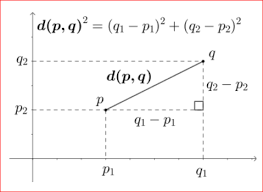


2. 해밍 거리(Hamming Distance)
  * 두 개의 문자열에서 같은 위치에 있는 서로 다른 문자 쌍의 갯수<p>
  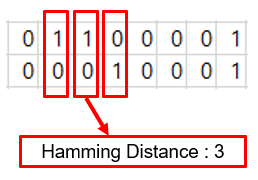

In [1]:
#구글 드라이브 마운트 하기
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1]
 [1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1]
 [1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
ffffffffffffffffffcfff97f81fe01fea1fe3bff3bff7bfffffffffffffffff


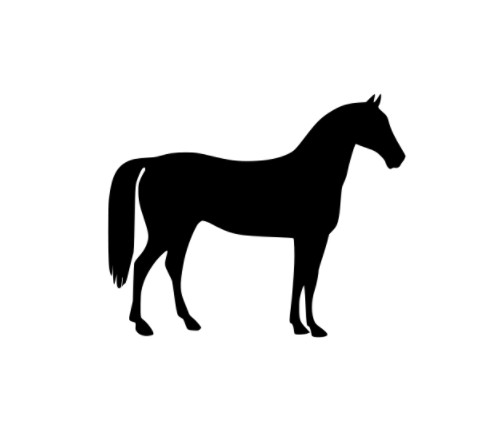

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/shapes/horse_shape.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 8*8 크기로 축소 <- 16,16이 아닐까?
gray = cv2.resize(gray, (16,16))
# 영상의 평균값 구하기
avg = gray.mean()
# 평균값을 기준으로 작으면 0, 크면 1로 변환
# 검은색=0, 흰색=255 -> 따라서 말 이미지의 배경이 1, 말 이미지가 0으로 표시
bin = 1 * (gray > avg)
print(bin)

# 2진수 문자열을 16진수 문자열로 변환
dhash = []
for row in bin.tolist():
  s = ''.join([str(i) for i in row])
  dhash.append('%02x'%(int(s, 2)))
dhash = ''.join(dhash)
print(dhash)

cv2_imshow(img)

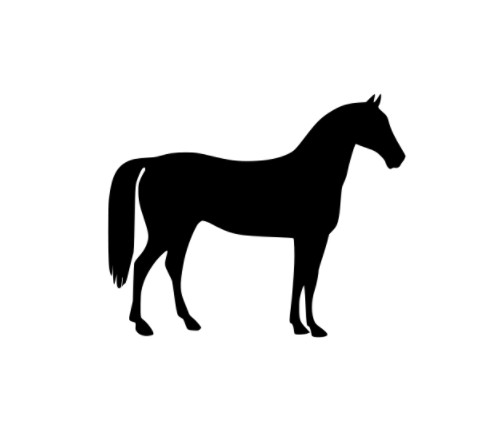

0.0


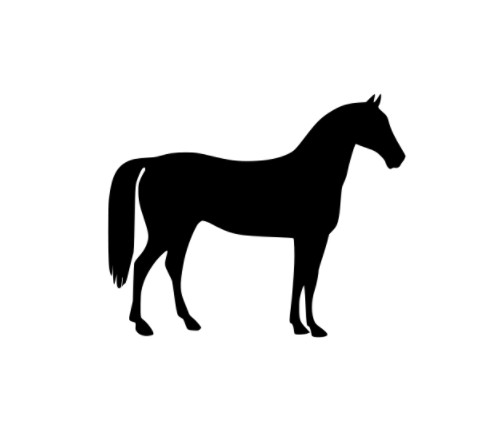

0.19921875


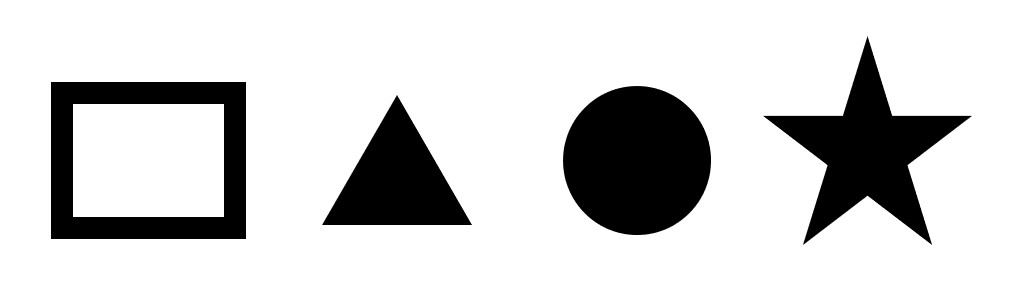

0.21484375


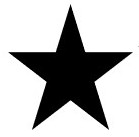

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import glob   # 파일을 가져올 수 있는 라이브러리

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/shapes/horse_shape.jpg')
search_dir = '/content/drive/MyDrive/Colab Notebooks/photos/shapes/'

cv2_imshow(img)

# 이미지를 16*16 크기의 평균 해쉬로 변환
def img2hash(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.resize(gray, (16,16))
  avg = gray.mean()
  bi = 1 * (gray > avg)
  return bi

# 해밍거리 측정 함수
def hamming_distance(a, b):
  a = a.reshape(1, -1)
  b = b.reshape(1, -1)
  # 같은 자리의 값이 서로 다른 것들의 합 <- 정확히 무슨 의미인지 
  distance = (a != b).sum()
  return distance

# 기준 이미지 해쉬 구하기
query_hash = img2hash(img)

# 이미지 데이터 셋 디렉토리의 모든 영상 파일 경로
img_path = glob.glob(search_dir + '/*.jpg')

#print(img_path)
#print(search_dir)

for path in img_path:
  #print(path)
  img_comp = cv2.imread(path)
  # 데이터 셋 영상 한 개의 해시
  a_hash = img2hash(img_comp)
  # 해밍 거리 산출
  dst = hamming_distance(query_hash, a_hash)
  if dst / 256 < 0.25: 
    # 해밍거리 25% 이내만 출력
    print(dst / 256)
    cv2_imshow(img_comp)
    

###01.2 템플릿 매칭(Template Matching)
* 템플릿 매칭은 특정 물체에 대한 이미지를 준비해 두고 그 물체가 포함되어 있을 것이라고 예상할 수 있는 이미지와 비교하여 매칭되는 위치를 찾음
* 템플릿 이미지는 비교할 이미지보다 크기가 항상 작아야 함
* cv2.matchTemplate() 함수는 입력 이미지(img)에서 템플릿 이미지(templ)를 슬라이딩 하면서 주어진 메서드에 따라 매칭을 수행
* cv2.matchTemplate() 함수의 반환 값은(입력 이미지의 가로-템플릿 이미지의 가로+1) * (입력 이미지의 세로-템플릿 이미지의 세로+1) 크기의 2차원배열
* 이 배열의 최대, 최소값을 구하면 원하는 최선의 매칭값과 매칭점을 구할 수 있음
  * cv2.minMaxLoc(): 입력 배열에서의 최소, 최대값과 최소값, 최대값의 좌표도 반환<p>
result = cv2.matchTemplate(img, temp1, method, result, mask)<p>

**Parameters:**

* img: 입력 이미지(=템플릿 이미지)
* method: 매칭 매서드
  * cv2.TM_SQDIFF: 제곱 차이 매칭, 완벽 매칭: 0, 나쁜 매칭: 값이 큼
  * cv2.TM_SQDIFF_NORMED: 제곱 차이 매칭의 정규화
  * cv2.TM_SCCORR: 상관관계 매칭, 완벽 매칭: 큰 값, 나쁜 매칭:0
  * cv2.TM_CCORR_NORMED: 상관관계 매칭의 정규화
  * cv2.TM_CCOEFF: 상관계수 매칭, 완벽 매칭:1, 나쁜 매칭:-1
  * cv2.TM_CCOEFF_NORMED: 상관계수 매칭의 정규화
* reuslt(optional): 매칭 결과, (W-w+1) * (H-h+1) 크기의 2차원 배열
* mask(optional): TM_SQDIFF, TM_CCORR_NORMED인 경우 사용할 마스크<p>

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(src, mask)<p>

**Parameters:**

* src: 입력 1 채널 배열
* minVal, maxVal: 배열전체에서의 최소값, 최대값
* minLoc, maxLoc: 최소값과 최대값의 좌표(x, y)

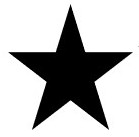

cv2.TM_CCOEFF_NORMED -0.36336880922317505 0.9999285340309143 (118, 72) (22, 150)


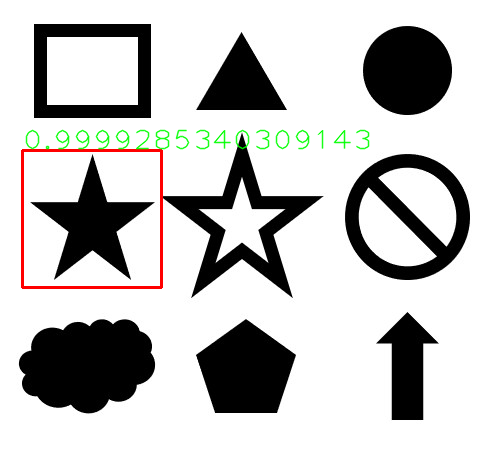

cv2.TM_CCORR_NORMED 0.5985453724861145 0.9999807476997375 (111, 260) (22, 150)


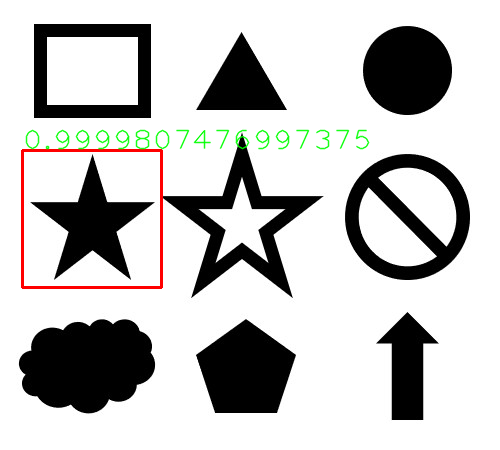

cv2.TM_SQDIFF_NORMED 3.890255175065249e-05 0.8060685396194458 (22, 150) (111, 260)


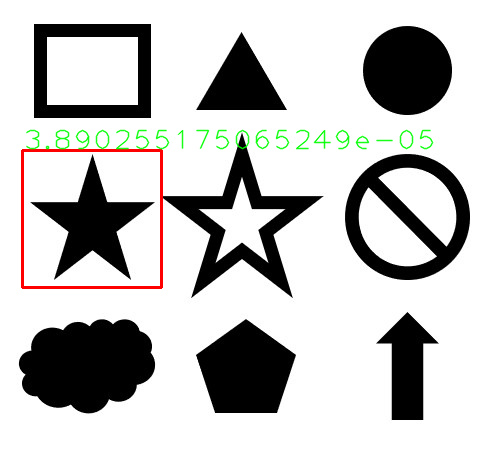

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import glob   # 파일을 가져올 수 있는 라이브러리

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/shapes/shapes.jpg')
template = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/shapes/star_shape.jpg')

th, tw = template.shape[:2]
cv2_imshow(template)

# 3가지 매칭 옵션
methods = ['cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF_NORMED']
for i, method_name in enumerate(methods):
  img_draw = img.copy()
  method = eval(method_name)
  #템플릿 매칭
  res = cv2.matchTemplate(img, template, method)
  # 최대, 최소값과 그 좌표 구하기
  min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
  print(method_name, min_val, max_val, min_loc, max_loc)

  #TM_SQDIFF의 경우 최소값이 좋은 매칭, 나머지는 그 반대
  if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED] :
    top_left = min_loc
    match_val = min_val
  else:
    top_left = max_loc
    match_val = max_val
  # 매칭 좌표 구해서 사각형 표시
  bottom_right = (top_left[0] + tw, top_left[1] + th)
  cv2.rectangle(img_draw, top_left, bottom_right, (0,0,255), 2)

  # 매칭 포인트 표시
  cv2.putText(img_draw, str(match_val), top_left, cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0), 1, cv2.LINE_AA)
  cv2_imshow(img_draw)

###01.3 복수 템플릿 매칭

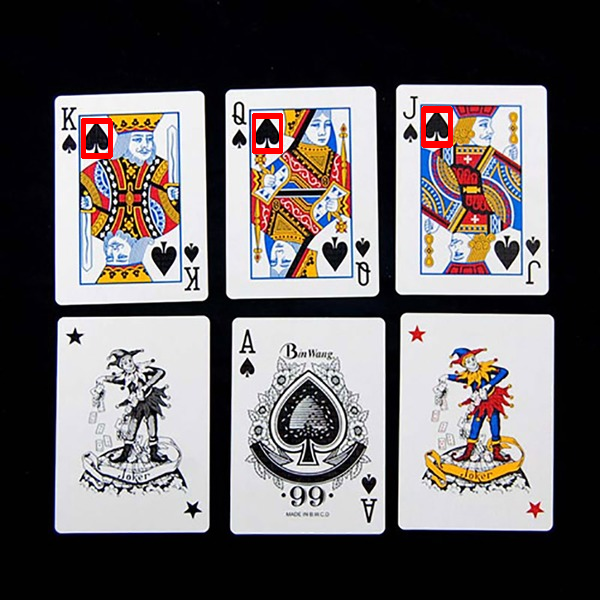

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import glob   # 파일을 가져올 수 있는 라이브러리

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/card.jpg')
template = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/card_template.jpg', cv2.IMREAD_GRAYSCALE)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

w, h = template.shape[::-1]
res = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):
  cv2.rectangle(img, pt, (pt[0] + w, pt[1]+h), (0,0,255), 2)

cv2_imshow(template)
cv2_imshow(img)

##02 이미지의 특징
* 이미지 특징점(keypoints): 이미지에서 특징이 되는 부분
* 이미지끼리 서로 매칭이 되는지 확인을 할 때 각 이미지에서의 특징이 되는 부분끼리 비교
* 보통 특징점이 되는 부분은 물체의 모서리나 코너

###02.1 해리스 코너 검출(Harris Corner Detection)
* 물체를 인식할 때 물체의 코너가 중요
* 해리스 코너 검출은 소벨(Sobel)미분으로 경계값을 검출하면서 경계값의 경사도 변화량을 측정하여 변화량이 수직, 수평, 대각선 방향으로 크게 변화하는 부분을 코너로 판단
* Harris 함수의 변환한 값에 임계점을 설정해서 사용(후처리 필요)
<p>
dst = cv2.cornerHarris(src, blockSize, ksize, k, dst, borderType)
<p>
**Parameters:**
* src: 입력 이미지, 그레이 스케일
* blockSize: 이웃 픽셀 범위
* ksize: 소벨 미분 필터 크기
* k(optional): 코너 검출 상수(보통 0.04~0.06)
* dst(optional): 코너 검출 결과(src와 같은 크기의 1채널 배열, 변화량의 값, 지역 최대값이 코너점을 의미)
* borderType(optional): 외곽 영역 보정 형식

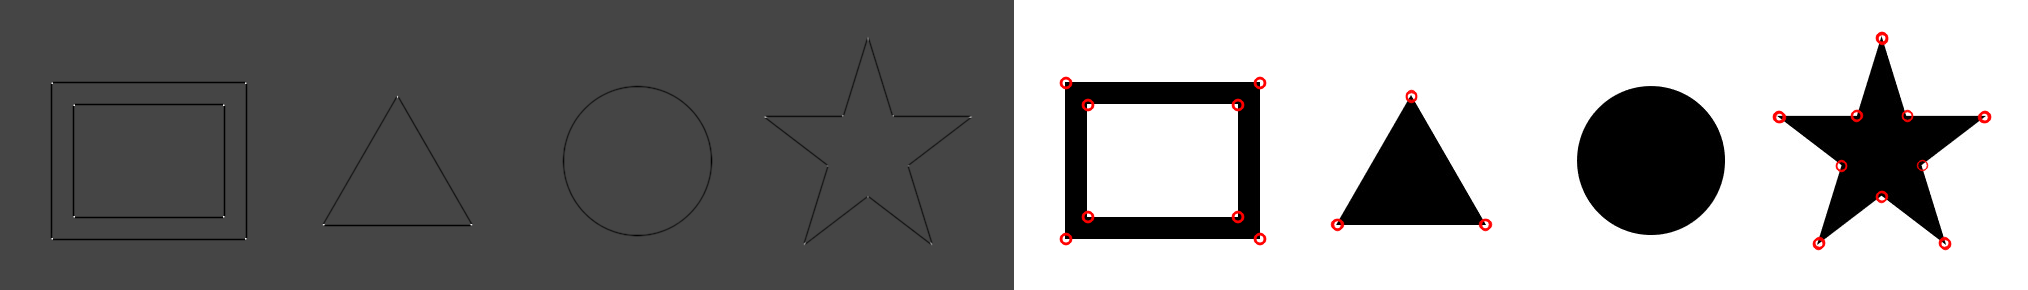

In [ ]:
import cv2
import numpy as np

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/shapes/4shapes.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 해리스 코너 검출
corner = cv2.cornerHarris(gray, 2, 3, 0.04)
# 변화량 결과의 최대값 10% 이상의 좌표 구하기
coord = np.where(corner > 0.1 * corner.max())
coord = np.stack((coord[1], coord[0]), axis=-1)

# 코너 좌표에 동그라미 그리기
for x, y in coord:
  cv2.circle(img, (x,y), 5, (0,0,255), 1, cv2.LINE_AA)

# 변화량을 영상으로 표현하기 위해서 0-255로 정규화
corner_norm = cv2.normalize(corner, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# 화면에 출력
corner_norm = cv2.cvtColor(corner_norm, cv2.COLOR_GRAY2BGR)
merged = np.hstack((corner_norm, img))
cv2_imshow(merged)

###02.2 시-토마시 검출(Shi & Tomasi Detection)
* 해리스 코너 검출을 개선한 알고리즘
<P>
corners = cv2.goodFeaturesToTrack(img, maxCorners, qualityLevel, minDistance, corners, mask, blocksize, useHarrisDetector, k)
<p>
**Parameters:**
* img: 입력 이미지
* maxCorners: 얻고 싶은 코너 갯수, 강한 것 순으로
* qualityLevel: 코너로 판단할 스레시홀드 값
* minDistance: 코너 간 최소 거리
* mask(optional): 검출에 제외할 마스크
* blockSize(optional)=3: 코너 주변 영역의 크기
* useHarrisDetector(optional)=False: 코더 검출 방법 선택
  * True: 해리스 코너 검출 방법
  * False: 시와 코마시 코너 검출 방법
* k(optional): 해리스 코너 검출 방법에 사용할 k 계수
* corners: 코너 검출 좌표 걸과, N*1(2 크기의 배열, 실수값이므로 정수로 변형 필요

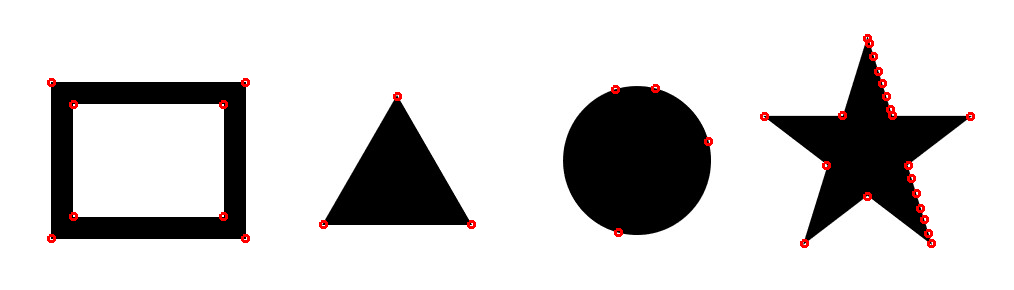

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/shapes/4shapes.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 코너검출
corners = cv2.goodFeaturesToTrack(gray, 100, 0.01, 5, blockSize=3, useHarrisDetector=False, k=0.03)

for i in corners:
  cv2.circle(img, tuple(i[0]), 3, (0,0,255), 2)

cv2_imshow(img)

###02.3 FAST(Features from Accelerated Segment Test)
* 다른 방식에 비해 득징점 추출의 정확도는 떨어지지만 실시간에서 활용할 수 있는 속도를 제공하면서 어느 정도의 특징점 추출 방법
* 특정 화소 인근의 화소값을 16개 뽑고 특정 화소 점보다 임계치를 더한 값보다 밝거나 임계치를 뺀 값보다 어두운 것들이 9개 이상이면 코너로 판단<p>
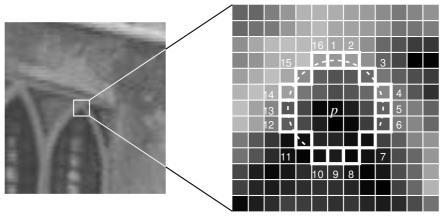
<p>
* 특징점이 비슷한 부분에서 너무 많이 추출되는 것을 방지하기 위해 억제(Non-maximal Supporession)하는 절차가 필요
* 근 픽셀 화소값 비교를 위한 임계치 기본값은 10이고, 비슷한 지점에서 너무 많은 특징점이 추출되는 것을 방지하기 위한 nonmaxSuppression 이 True로 지정
<p>
cv2.FastFeatureDetector_create(, threshold=None, nonmaxSuppression=None, Type=None) -> retval
<p>
**Parameters:**
* threshold: 중심 픽셀 값과 주변 픽셀 값과의 차이 임계값, 기본은 10. 30~60 적절
* nonmaxSuppression: 비최대 억제 수행 여부. 기본값은 True
* type: 코너 검출 방법. 기본값은 cv2.FAST_FEATURE_DETECTOR_TYPE_9_16
* retval: FastFeatureDetector 객체

Threshold= 70
nonmaxSuppression= False
neighborhood= 2
Total Keypoints with nonmaxSuppression= 1204


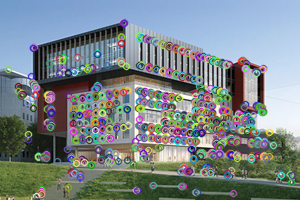

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/building2_300x200.jpg')

fast = cv2.FastFeatureDetector_create()
fast.setThreshold(70) # threshold 값이 낮으면 너무 많은 코너가 검출된다. 너무 높으면 적게 검출된다.
fast.setNonmaxSuppression(False)

kp = fast.detect(img, None)
result = cv2.drawKeypoints(img, kp, None)

print('Threshold=', fast.getThreshold())
print('nonmaxSuppression=', fast.getNonmaxSuppression())
print('neighborhood=', fast.getType())
print('Total Keypoints with nonmaxSuppression=', len(kp))

cv2_imshow(result)

##03 얼굴 추적(Haar Cascades)
* Haar Cascades 기법: Paul Viola와 Michael Jones가 2001년에 발표한 논문 "Rapid Object Detection using a Boosted Cascade of Simple Features"에서 제안된 효과적인 물체 검출 방법
* 얼굴의 특징. 눈, 입은 가로, 코는 세로.. 이런 특징을 이미지에서 찾는다.
* 검출할 대상이 되는 물체가 있는 이미지(Positive Image)와 물체가 아닌 이미지(Negative Image)를 최대한 많이 활용해 다단계 함수를 훈련시키는 기계학습 방식
* 이 알고리즘은 분류자(Classifier)를 훈련시키기 위해 매우 많은 훈련용 이미지가 필요
* 이미지의 특징을 추출하기 위해 Haar feature가 사용됨
  * 컨볼루션 커널(Convolutional Kernel)과 같음
  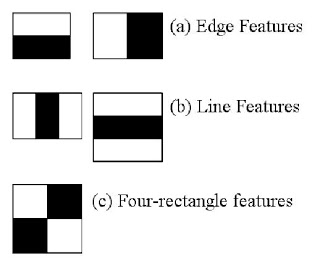
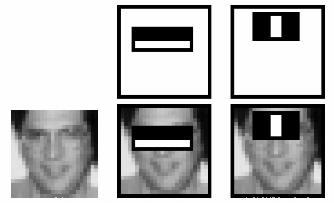
* 트레이닝 결과를 xml 형태로 저장
* Cascade of Classifiers의 개념
  * 이미지에 6000개의 모든 특징을 적용하는 대신, 분류자의 다른 단계로 특징을 묶고 하나씩 하나씩 적용
  * 몇몇의 특징을 찾는데 실패하면 다른 특징도 찾지 않고 버림
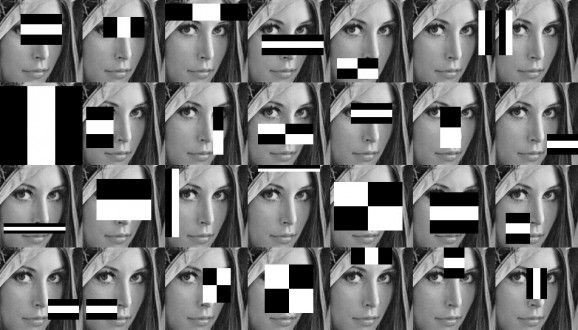
cv2.CascadeClassifier.detectMultiScale(image, scaleFactor, minNeighbors)<p>
**Parameters:**
* image: 입력 이미지
* scaleFactor: 이미지 축소 비율
* minNeighbors: 얼마나 많은 이웃 사각형이 검출되어야 최종 검출영역으로 설정할 것인지 지정.
  * 기본값은 3
  * 숫자가 클수록 얼굴이 더 적게 검출되지만 정확도가 높아짐.

In [ ]:
from IPython.display import HTML
HTML('<iframe height="400" src="https://www.youtube.com/embed/hPCTwxF0qf4" frameborder="0" allow="accelerometer; autoplay; encrypted-media;"></iframe>')

###03.1 얼굴 검출

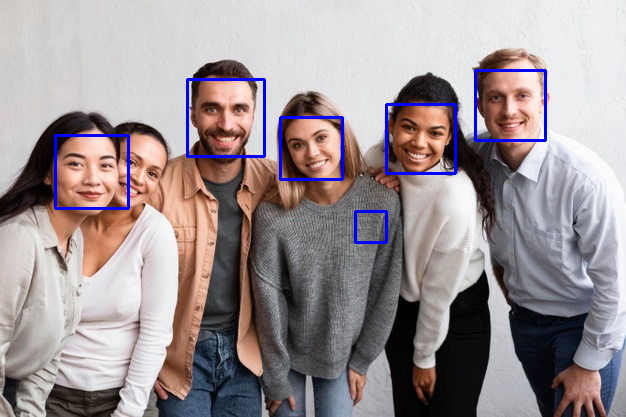

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/people.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 미리 여러장의 얼굴 사진을 통해 특징을 기록한 xml 파일을 사용한다.
# github.com/opencv/opencv/tree/3.4/data/haarcascades 에서 파일을 다운로드 한다.
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

faces = face_cascade.detectMultiScale(gray, 1.3, 1) 
# 7개의 사각형이 검출되면 얼굴로 인식하도록 했는데, 검출이 안되는 얼굴이 있으므로 숫자를 줄였다.
# 숫자를 줄이니, 얼굴이 아닌 다른 부분도 얼굴로 인식했다.
# 이미지를 많이 트레이닝 시켜야 한다.

for (x,y,w,h) in faces:
  cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)

cv2_imshow(img)

###03.2 눈 검출

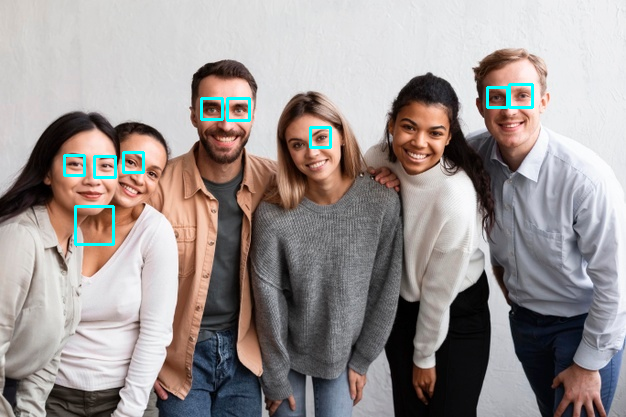

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/people.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 미리 여러장의 얼굴 사진을 통해 특징을 기록한 xml 파일을 사용한다.
# github.com/opencv/opencv/tree/3.4/data/haarcascades 에서 파일을 다운로드 한다.
eye_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_eye.xml'))

faces = eye_cascade.detectMultiScale(gray, 1.3, 1) 
# 1보다 작게 줄 수 없다. 0으로 변경하니 다른 영역도 눈으로 인식했다.
# 얼굴이 사선으로 된 경우, 눈이 검출되지 않았다.

for (x,y,w,h) in faces:
  cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,0), 2)

cv2_imshow(img)

###03.3 얼굴과 눈 검출
* 위와 같이 눈이 검출되지 않는 경우, 얼굴을 먼저 검출하고 얼굴 안에서 눈을 검출하도록 한다.

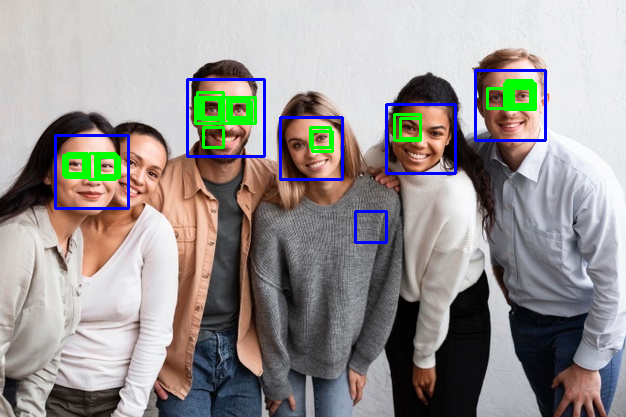

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/people.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 미리 여러장의 얼굴 사진을 통해 특징을 기록한 xml 파일을 사용한다.
# github.com/opencv/opencv/tree/3.4/data/haarcascades 에서 파일을 다운로드 한다.
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
eye_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_eye.xml'))

faces = face_cascade.detectMultiScale(gray, 1.3, 1) 

# 얼굴 영역을 먼저 찾고, 얼굴 영역 안에서 눈을 찾는다.
for (x,y,w,h) in faces:
  cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
  roi_gray = gray[y:y+h, x:x+w]
  roi_color = img[y:y+h, x:x+w]
  eyes = eye_cascade.detectMultiScale(roi_gray, 1.3, 0)
  for (ex, ey, ew, eh) in eyes:
    cv2.rectangle(roi_color, (ex,ey), (ex+ew, ey+eh), (0,255,0), 2)

cv2_imshow(img)

###03.4 웃는 입 검출

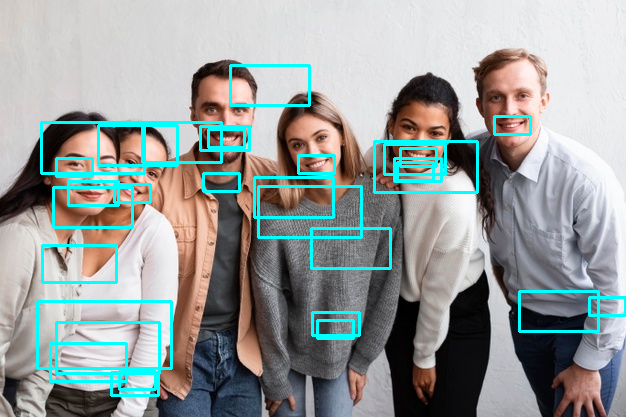

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/people.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

smile_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_smile.xml'))
smiles = smile_cascade.detectMultiScale(gray, 1.3, 2) 

for (x,y,w,h) in smiles:
  cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,0), 2)

cv2_imshow(img)

###03.5 얼굴과 웃는 입 검출

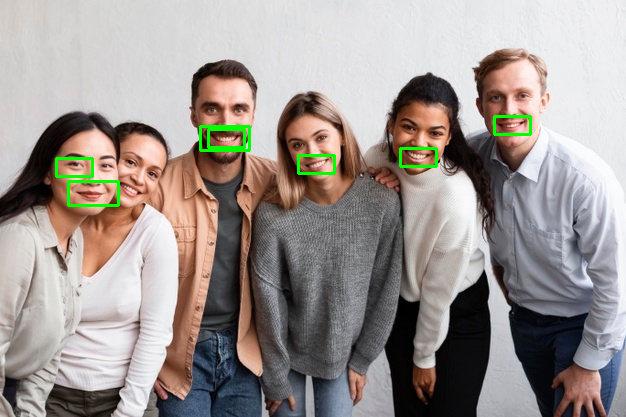

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/photos/people.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 미리 여러장의 얼굴 사진을 통해 특징을 기록한 xml 파일을 사용한다.
# github.com/opencv/opencv/tree/3.4/data/haarcascades 에서 파일을 다운로드 한다.
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
smile_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_smile.xml'))

faces = face_cascade.detectMultiScale(gray, 1.3, 1) 
smiles = smile_cascade.detectMultiScale(gray, 1.3, 2) 

# 얼굴 영역을 먼저 찾고, 얼굴 영역 안에서 눈을 찾는다.
for (x,y,w,h) in faces:
  for (xs, ys, ws, hs) in smiles:
    if ((x<=xs) and (y<=ys) and (x+w>=xs+ws) and (y+h>=ys+hs)):
      cv2.rectangle(img, (xs,ys), (xs+ws, ys+hs), (0,255,0), 2)

cv2_imshow(img)

###04 코랩에서 비디오 카메라 사용하기
Code Snippets 탭 선택 -> Camera Capture 검색 -> 코드 삽입

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='myphoto.jpg', quality=0.9):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to myphoto.jpg


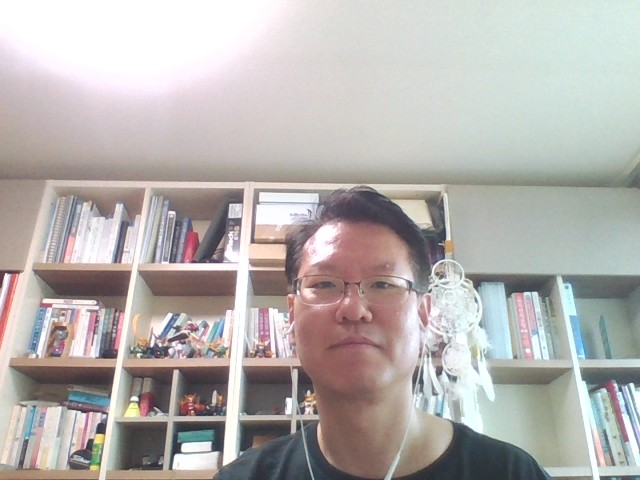

In [4]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

###04.1 필요한 라이브러리를 가져오기

In [5]:
#import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

###04.2 다른 확장자와 형식을 가진 이미지를 변환

In [7]:
#자바 스크립트 형식의 이미지를 OpenCV 이미지 형식에 맞게 변환
def js_to_image(js_reply):
  #base64 이미지로 디코드
  image_bytes = b64decode(js_reply.split(',')[1])
  #넘파이 배열로 변환
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  #넘파이 배열을 OpenCV BGR 이미지로 변환
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img


###04.3 Haar Cascade Classifier 파일 불러오기


In [8]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))


###04.4 웹캠 연결하고 사진 찍는 함수 설정

In [9]:
def take_photo(filename='myphoto.jpg', quality=0.9):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # 사진 데이터 가져오기
  data = eval_js('takePhoto({})'.format(quality))
  # openCV 포맷으로 변환
  img = js_to_image(data)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Haar Cascade 함수를 사용해 얼굴 찾기
  faces = face_cascade.detectMultiScale(gray)
  for (x,y,w,h) in faces:
    img = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)

  # 이미지 저장하기
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

saved to photo.jpg


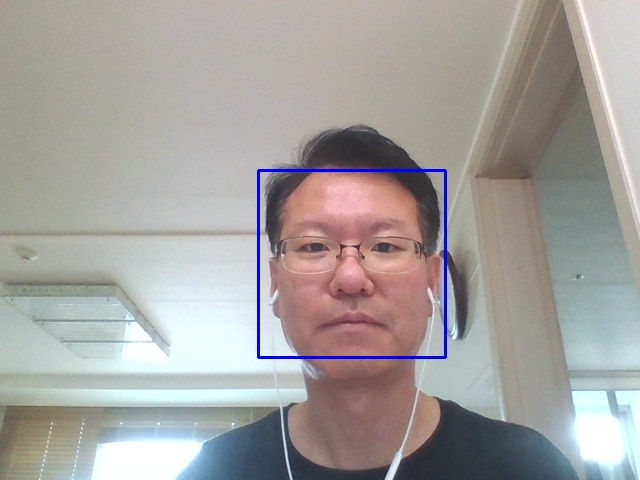

In [11]:
try:
  filename = take_photo('photo.jpg')
  print('saved to {}'.format(filename))

  display(Image(filename))
except Exception as err:
  print(str(err))

###04.5 실시간 얼굴 추적

In [12]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def bbox_to_bytes(bbox_array):
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [13]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>